In [1]:
import argparse
import glob
import os
import pathlib
import _pickle

import autograd.numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

import phlearn.phsystems as phsys
import phlearn.phnns as phnn

from scipy.integrate import solve_ivp
from scipy.sparse import diags

torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
ttype = torch.float32
torch.set_default_dtype(ttype)
%matplotlib notebook
#custom_colors = sns.color_palette([(1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0.6,0.8,.8), (0,0.4,1), (0.5,0.3,.5)])
custom_colors = sns.color_palette([(1,0.7,0.3), (0.8,0,0.2), (0.6,0.8,.8), (0,0.4,1), (0.5,0.3,.5)])
sns.set_palette(custom_colors)

plot_settings = {
    'axes.prop_cycle': mpl.cycler(color=custom_colors),
    'text.usetex': True,
    'font.family': 'serif',
    'axes.titlesize': 9,
    'figure.titlesize': 9,
    'legend.title_fontsize': 8,
    'axes.labelsize': 9,
    'font.size': 9,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'xtick.major.size': 8,
    'ytick.major.size': 8,
    'savefig.dpi': 300,
}


plt.rcParams.update(plot_settings)

In [2]:
modelfolder = 'trained_models_pm/'
df = pd.DataFrame(columns=['system_type', 'baseline', 'ntrainingpoints', 'sampling_time', 't_max', 'integrator',
                           'F_timedependent', 'F_spacedependent', 'F_statedependent', 'pHnn_model', 'val_loss'])
for f in glob.glob(modelfolder+"/*"):
    if ('DS_store' not in f) and ('.csv' not in f):
        model, optimizer, metadict = phnn.load_dynamic_system_model(f)
        #print('metadict[traininginfo]:', metadict['traininginfo'].keys())
        df.loc[f[18:]] = {'system_type': metadict['traininginfo']['system'],
                                   'baseline': int(metadict['traininginfo']['baseline']),
                                   'ntrainingpoints': metadict['traininginfo']['ntrainingpoints'],
                                   'sampling_time': metadict['traininginfo']['sampling_time'],
                                   't_max': metadict['traininginfo']['t_max'],
                                   'integrator': metadict['traininginfo']['integrator'],
                                   'F_timedependent': bool(metadict['traininginfo']['F_timedependent']),
                                   'F_spacedependent': bool(metadict['traininginfo']['F_spacedependent']),
                                   'F_statedependent': bool(metadict['traininginfo']['F_statedependent']),
                                   'val_loss': metadict['traininginfo']['val_loss'],
                                   'pHnn_model': model}

In [3]:
dt_rollout = 0.0002
extrapolate = False
t_max = .02
dt = 0.02
result_file = f'testresults_dt{dt_rollout:.0e}_n10_t{int(t_max)}.csv'
t_max = .02
stored_results_path = os.path.join(modelfolder, result_file)
stored_df = pd.read_csv(stored_results_path, index_col=0)

df.loc[stored_df.index, stored_df.columns] = stored_df.loc[stored_df.index, :].values.copy()

In [4]:
df = df[df['sampling_time'] == dt]
df['MSE'] = df['MSE']
df['Model type'] = df['baseline'].astype(int)
df['Model type'] = df['Model type'].map({1:'Baseline',
                                         3:'PHNN (general)', 0:'PHNN (informed)'})
#type_order = ['1N baseline', '2N baseline', 'PHNN (general)', 'PHNN (informed)']

In [5]:
df

,system_type,baseline,ntrainingpoints,sampling_time,t_max,integrator,F_timedependent,F_spacedependent,F_statedependent,pHnn_model,val_loss,MSE,MSE endtime,Model type
20230419182304631205.model,pm,2,10,0.02,0.02,srk4,False,True,False,DynamicSystemNN(\n (rhs_model): PDEBaselineSp...,11.686121,0.005739,0.014740,NaN
20230419192934214655.model,pm,3,10,0.02,0.02,srk4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,7.659395,0.000304,0.000518,PHNN (general)
20230419184436352641.model,pm,1,10,0.02,0.02,srk4,False,True,False,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,17.048891,0.001250,0.002561,Baseline
20230419183030282509.model,pm,1,10,0.02,0.02,srk4,False,True,False,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,21.238617,0.002131,0.003364,Baseline
20230419181502700747.model,pm,0,10,0.02,0.02,srk4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,10.213181,0.000228,0.000375,PHNN (informed)
20230419184747845217.model,pm,1,10,0.02,0.02,srk4,False,True,False,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,15.597709,0.000912,0.001078,Baseline
20230419181704717398.model,pm,0,10,0.02,0.02,srk4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,11.218140,0.000228,0.000396,PHNN (informed)
20230419181449159392.model,pm,0,10,0.02,0.02,srk4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,9.363010,0.000175,0.000266,PHNN (informed)
20230419182545587432.model,pm,1,10,0.02,0.02,srk4,False,True,False,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,17.391642,0.002181,0.003008,Baseline
20230419182924687739.model,pm,2,10,0.02,0.02,srk4,False,True,False,DynamicSystemNN(\n (rhs_model): PDEBaselineSp...,16.645910,0.001734,0.002320,NaN


In [6]:
custom_order = ['PHNN (general)', 'PHNN (informed)', 'Baseline']
df['Model type'] = pd.Categorical(df['Model type'], categories=custom_order)
# calculate mean and standard deviation of MSE endtime, grouped by Model type
result = df.groupby('Model type')['MSE endtime'].agg(['mean', 'std']).reset_index()
result = result.sort_values('Model type')
result['mean'] = result['mean'].apply(lambda x: '{:.2e}'.format(x))
result['std'] = result['std'].apply(lambda x: '{:.2e}'.format(x) if pd.notna(x) else '--')
print(result)

        Model type      mean       std
0   PHNN (general)  4.83e-04  3.62e-05
1  PHNN (informed)  3.38e-04  5.92e-05
2         Baseline  2.50e-03  1.00e-03


In [7]:
latex_table = result.to_latex(index=False, column_format='lS[table-format=1.2e]S[table-format=1.2e]')
print(latex_table)

\begin{tabular}{lS[table-format=1.2e]S[table-format=1.2e]}
\toprule
     Model type &     mean &      std \\
\midrule
 PHNN (general) & 4.83e-04 & 3.62e-05 \\
PHNN (informed) & 3.38e-04 & 5.92e-05 \\
       Baseline & 2.50e-03 & 1.00e-03 \\
\bottomrule
\end{tabular}



/var/folders/qt/5hnkklzx3qz34g37fvg7b2h80000gn/T/ipykernel_65206/3320516013.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = result.to_latex(index=False, column_format='lS[table-format=1.2e]S[table-format=1.2e]')


In [8]:
x_max = 6
x_points = 300
dx = x_max/x_points
x = np.linspace(0,x_max-dx,x_points)
def F(u, t):
    return 10*np.sin(2*2*np.pi/x_max*x)
def JF(u,t):
    return np.zeros((u.shape[0],u.shape[0]))
PDE_system = phsys.PeronaMalikSystem(x=x, force=F, force_jac=JF,
                                 init_sampler=phsys.initial_condition_pm(x))

<IPython.core.display.Javascript object>


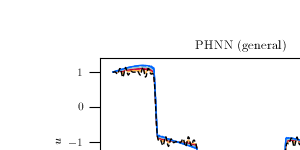

In [9]:
t_max = .02
a = 1
d1, d2 = 1., 2.
k1, k2 = 2., 15.
n1, n2 = 30., 0.15
P = (x[-1]-x[0])*x.size/(x.size-1)
u0 = a - np.tanh(n1*(x-d1)) + np.tanh(n1*(x-x_max+d1))
u0 += - np.tanh(n1*(x-d2)) + np.tanh(n1*(x-x_max+d2))
u0 += n2*np.sin(k1*np.pi*x)**2*np.sin(k2*np.pi*x)

bestmodels = []
for modeltype, grp in df.groupby('Model type'):
    bestmodelstats = grp.sort_values('MSE').iloc[0]
    bestmodel, _, bestmodel_metadict = phnn.load_dynamic_system_model(modelfolder+'/'+bestmodelstats.name)
    bestmodels += [(bestmodel, bestmodelstats, bestmodel_metadict, modeltype)]
    
seeds = [20]
for seed in seeds:
    PDE_system.seed(seed)
    x = PDE_system.x
    u_exact_orig, dudt, t_sample, _ = PDE_system.sample_trajectory(np.arange(0, t_max+dt_rollout, dt_rollout), x0=u0)
    N = t_sample.shape[0]-1
    #u0 = u_exact_orig[0, :]
    fig = plt.figure(figsize=(8, 4.8))
    col = 1
    for pHnn_model, modelstats, modeldict, modeltype in bestmodels:
        ax1 = fig.add_subplot(2, 2, col)
        ax1.set_title(modeltype)

        u_phnn, _ = pHnn_model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        for i in range(1,5):
            ax1.plot(x, u_exact_orig[int(i*N/4),:], color=custom_colors[i-1], linestyle='--', linewidth=1, label=f't = {i/4*t_max}, true')
            ax1.plot(x, u_phnn[int(i*N/4),:], color=custom_colors[i-1], linewidth=1, label=f't = {i/4*t_max}, model') 
        ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='--', linewidth=1, label='Initial condition') 
        ax1.set_xlabel('$x$')
        ax1.set_ylabel('$u$')
        col += 1
    ax1.legend(bbox_to_anchor=(-0.19, -0.23), loc='upper center', ncol=5, fancybox=True)
    #fig.tight_layout()
    #fig.savefig('figs/paper/pm_1.pdf', bbox_inches='tight')

In [10]:
model_solutions_original = []
for pHnn_model, modelstats, modeldict, modeltype in bestmodels:
    u_model, _ = pHnn_model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
    model_solutions_original.append((u_model, modeltype, 'Original'))

In [11]:
# u_max, u_min = u_exact_orig.max(), u_exact_orig.min()
# for (u, _, _) in model_solutions_original:
#     if u.max() > u_max:
#         u_max = u.max()
#     if u.min() < u_min:
#         u_min = u.min()
# #u_min = max(u_min, -2)
# #u_max = min(u_max, 10)

# N = t_sample.shape[0]-1
# u0 = u_exact_orig[0, :]
# fig = plt.figure(figsize=(8, 1.6))
# ax1 = fig.add_subplot(1, 3, 1)
# col = 2
# ax1.set_title('Initial value')
# ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='--', linewidth=1)
# ax1.set_ylim([1.1*u_min, 1.1*u_max])
# ax1.set_ylabel('$u$')
# ax1.set_xlabel('$x$')
# for i in range(1,3):
#     ax1 = fig.add_subplot(1, 3, col)
#     ax1.set_title(f'$t = {i/2*t_max}$')
#     for j, (u, modeltype, _) in enumerate(model_solutions_original):
#         ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j], linewidth=1, label=modeltype) 
#     ax1.plot(x, u_exact_orig[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#     ax1.set_xlabel('$x$')
#     ax1.set_yticks([])
#     ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     col += 1
# ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
# #fig.tight_layout()
# fig.subplots_adjust(wspace=0.1)
# fig.savefig('figs/paper/pm_time.pdf', bbox_inches='tight')

In [12]:
# u_max, u_min = u_exact_orig.max(), u_exact_orig.min()
# for (u, _, _) in model_solutions_original:
#     if u.max() > u_max:
#         u_max = u.max()
#     if u.min() < u_min:
#         u_min = u.min()
# #u_min = max(u_min, -2)
# #u_max = min(u_max, 10)

# N = t_sample.shape[0]-1
# u0 = u_exact_orig[0, :]
# fig = plt.figure(figsize=(8, 1.))
# ax1 = fig.add_subplot(1, 5, 1)
# col = 2
# ax1.set_title('Initial value')
# ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='--', linewidth=1)
# ax1.set_ylim([1.1*u_min, 1.1*u_max])
# ax1.set_ylabel('$u$')
# ax1.set_xlabel('$x$')
# for i in range(1,5):
#     ax1 = fig.add_subplot(1, 5, col)
#     ax1.set_title(f'$t = {i/4*t_max}$')
#     for j, (u, modeltype, _) in enumerate(model_solutions_original):
#         if modeltype=='PHNN (general)':
#             ax1.plot(x, u[int(i*N/4),:], color=custom_colors[j], linewidth=1, label=modeltype) 
#     ax1.plot(x, u_exact_orig[int(i*N/4),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#     ax1.set_xlabel('$x$')
#     ax1.set_yticks([])
#     ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     col += 1
# ax1.legend(bbox_to_anchor=(-1.63, -0.55), loc='upper center', ncol=5, fancybox=True)
# #fig.tight_layout()
# fig.subplots_adjust(wspace=0.1)
# fig.savefig('figs/paper/pm_time.pdf', bbox_inches='tight')

#### Removing the external force

In [13]:
PDE_system_no_force = phsys.PeronaMalikSystem(x=x, force=None, force_jac=None,
                                 init_sampler=phsys.initial_condition_pm(x))
u_exact_no_force, _, _, _ = PDE_system_no_force.sample_trajectory(np.arange(0, t_max+dt_rollout, dt_rollout), x0=u0)

In [14]:
model_solutions_no_force = []
for model, modelstats, modeldict, modeltype in bestmodels:
    if modeltype=='Baseline':
        def basemodel_no_force(u, t, x):
            return (model.rhs_model(u,t,x) - 
                    model.rhs_model(torch.zeros_like(u),t,x))
        u_dot = lambda t, u: basemodel_no_force(
                                 torch.tensor(u.reshape(1, u.shape[-1]), dtype=ttype),
                                 torch.tensor(np.array(t).reshape((1, 1)), dtype=ttype),
                                 torch.tensor(x.reshape(1, x.shape[-1]), dtype=ttype)
                                 ).detach().numpy().flatten()
        out_ivp = solve_ivp(fun=u_dot, t_span=(t_sample[0], t_sample[-1]),
                            y0=u0.flatten(), t_eval=t_sample, rtol=1e-10)
        u_model = out_ivp['y'].T
        model_solutions_no_force.append((u_model, modeltype, 'No force'))
    else:
        phmodel = phnn.ConservativeDissipativeNN(
                                                 PDE_system.nstates,
                                                 kernel_sizes=model.kernel_sizes[:3]+[0],
                                                 structure_matrix=model.S(),
                                                 dissipation_matrix=model.P(),
                                                 symmetric_matrix=model.D_flat(),
                                                 hamiltonian_true=model.hamiltonian,
                                                 grad_hamiltonian_true=model.dH,
                                                 dissintegral_true=model.dissintegral,
                                                 grad_dissintegral_true=model.dV
                                                )
        u_model, _ = phmodel.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        model_solutions_no_force.append((u_model, modeltype, 'No force'))

In [15]:
# u_max, u_min = u_exact_no_force.max(), u_exact_no_force.min()
# for (u, _, _) in model_solutions_no_force:
#     if u is not None:
#         if u.max() > u_max:
#             u_max = u.max()
#         if u.min() < u_min:
#             u_min = u.min()
# #u_min = min(max(u_min, -2), -.15)
# #u_max = min(u_max, 6)

# N = t_sample.shape[0]-1
# u0 = u_exact_orig[0, :]
# fig = plt.figure(figsize=(8, 1.6))
# ax1 = fig.add_subplot(1, 3, 1)
# col = 2
# ax1.set_title('Initial value')
# ax1.plot(x, u_exact_no_force[0,:], color='k', linestyle='--', linewidth=1)
# ax1.set_ylim([1.1*u_min, 1.1*u_max])
# ax1.set_ylabel('$u$')
# ax1.set_xlabel('$x$')
# for i in range(1,3):
#     ax1 = fig.add_subplot(1, 3, col)
#     ax1.set_title(f'$t = {i/2*t_max}$')
#     for j, (u, modeltype, _) in enumerate(model_solutions_no_force):
#         if u is not None:
#             ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j+1], linewidth=1, label=modeltype) 
#     ax1.plot(x, u_exact_no_force[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#     ax1.set_xlabel('$x$')
#     ax1.set_yticks([])
#     ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     col += 1
# ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
# #fig.tight_layout()
# fig.subplots_adjust(wspace=0.1)
# #fig.savefig('figs/paper/pm_time.pdf', bbox_inches='tight')

#### Plotting all models

In [16]:
all_models = [model_solutions_original, model_solutions_no_force]
all_exact = [u_exact_orig, u_exact_no_force]
model_names = ['Baseline', 'PHNN (general)', 'PHNN (informed)']

# col = 1

# fig = plt.figure(figsize=(8, 5))

# for m, model_solution in enumerate(all_models):
    
#     u_exact = all_exact[m]
#     model_solutions = all_models[m]
#     u_max, u_min = u_exact.max(), u_exact.min()
#     u_max = max(u.max() for (u, _, _) in model_solutions if u is not None)
#     u_min = min(u.min() for (u, _, _) in model_solutions if u is not None)
#     #u_min = min(max(u_min, -2), -.15)
#     #u_max = min(u_max, 6)
    
#     ax1 = fig.add_subplot(3, 3, 1+3*m)
    
#     if m == 0:
#         ax1.set_title('Initial value')
#     if m != 2:
#         ax1.set_xticks([])
#     ax1.plot(x, u_exact_no_force[0,:], color='k', linestyle='--', linewidth=1)
#     ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     ax1.set_ylabel('$u$')
#     if m == 2:
#         ax1.set_xlabel('$x$')
        
#     for i in range(1,3):
#         ax1 = fig.add_subplot(3, 3, 1+i+3*m)
#         if m == 0:
#             ax1.set_title(f'$t = {i/2*t_max}$')
#         if m != 2:
#             ax1.set_xticks([])
#         for j, (u, modeltype, _) in enumerate(model_solution):
#             if u is not None:
#                 ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j], linewidth=1, label=modeltype) 
#         ax1.plot(x, u_exact[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#         if m == 2:
#             ax1.set_xlabel('$x$')
#         ax1.set_yticks([])
#         ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     if m == 0:
#         ax1.legend(bbox_to_anchor=(-0.6, -2.77), loc='upper center', ncol=3, fancybox=True)

# #ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
# fig.subplots_adjust(wspace=0.1)
# fig.savefig('figs/paper/pm_all.pdf', bbox_inches='tight')

In [17]:
# col = 1

# fig = plt.figure(figsize=(8, 4.7))

# for m, model_solution in enumerate(all_models):

#     u_exact = all_exact[m]
#     model_solutions = all_models[m]
#     u_max, u_min = u_exact.max(), u_exact.min()
#     u_max = max(u.max() for (u, _, _) in model_solutions if u is not None)
#     u_min = min(u.min() for (u, _, _) in model_solutions if u is not None)
# # #     u_min = min(max(u_min, -2), -.15)
# # #     u_max = min(u_max, 6)
# #     u_min = -.5
# #     u_max = 2.2
        
#     for jp, (u, modeltype, _) in enumerate(model_solution):
#         if jp < 2:
#             j = jp + 2
#         else:
#             j = jp - 2
#         if u is not None:
#             ax1 = fig.add_subplot(3, 4, j+1+4*m)
#             if m == 0:
#                 ax1.set_title(modeltype)
#             ax1.plot(x, u[-1,:], color=custom_colors[j], linewidth=1, label=modeltype) 
#             ax1.plot(x, u_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#             if (m == 2) or (m == 1 and j > 1):
#                 ax1.set_xlabel('$x$')
#             else:
#                 ax1.set_xticks([])
#             if j == 0:
#                 ax1.set_ylabel(model_solution[-1][-1]+'\n$u$')
#             else:
#                 ax1.set_yticks([])
#             ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     #if m == 0:
#     #    ax1.legend(bbox_to_anchor=(-0.6, -2.77), loc='upper center', ncol=3, fancybox=True)

# #ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
# fig.subplots_adjust(wspace=0.1)
# #fig.savefig('figs/paper/pm_spread.pdf', bbox_inches='tight')

#### Extracting the force term

In [18]:
model_forces = []
for model, modelstats, modeldict, modeltype in bestmodels:
    if modeltype=='Baseline':
        F_model = model.rhs_model(
                       torch.zeros_like(torch.tensor(u_model.reshape(-1,1,u_model.shape[-1]), dtype=ttype)),
                       torch.tensor(t_sample.reshape(-1,1,1),dtype=ttype),
                       torch.tensor(np.tile(x.reshape(-1, 1, 1), u_model.shape[0]).T, dtype=ttype)
                      ).detach().numpy().reshape(u_model.shape)
        model_forces.append((F_model, modeltype, 'Force'))
    else:
        u_model, _ = model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        F_model = model.external_forces(torch.tensor(u_model.reshape(-1,1,u_model.shape[-1]), dtype=ttype),
                                        torch.tensor(t_sample.reshape(-1,1,1),dtype=ttype),
                                        torch.tensor(np.tile(x.reshape(-1, 1, 1), u_model.shape[0]).T, dtype=ttype)
                                       ).detach().numpy().reshape(u_model.shape)
        if model.kernel_sizes[0] > 1:
            d = int((model.kernel_sizes[0]-1)/2)
            M = x.size
            D_flat = model.D_flat().detach().numpy()
            diagonals = np.concatenate([D_flat[0,:,(d+1):], D_flat[0], D_flat[0,:,:-(d+1)]], axis=1).T.repeat(M, axis=1)
            offsets = np.concatenate([np.arange(-M+1,-M+1+d),np.arange(-d,d+1),np.arange(M-d,M)])
            D = diags(diagonals, offsets, (M,M)).toarray()
            F_model = np.matmul(PDE_system.lhs_matrix, np.linalg.solve(D, F_model.T)).T
        model_forces.append((F_model, modeltype, 'Force'))
F_exact = PDE_system.external_forces(u_exact_orig, t_sample).reshape(1,-1)

In [19]:
# col = 1

# fig = plt.figure(figsize=(8, 4.5))

# for mp, model_solution in enumerate(all_models):
#     if mp > 0:
#         m = mp+1
#     else:
#         m = mp

#     u_exact = all_exact[mp]
#     model_solutions = all_models[mp]
#     u_max, u_min = u_exact.max(), u_exact.min()
#     u_max = max(u.max() for (u, _, _) in model_solutions if u is not None)
#     u_min = min(u.min() for (u, _, _) in model_solutions if u is not None)
# #    u_min = min(max(u_min, -2), -.15)
# #     u_max = min(u_max, 6)
# #    u_min = -.5
# #    u_max = 2.2
        
#     for jp, (u, modeltype, _) in enumerate(model_solution):
# #         if jp < 2:
# #             j = jp + 2
# #         else:
# #             j = jp - 2
#         j = jp
#         if u is not None:
#             ax1 = fig.add_subplot(3, 3, j+1+3*m)
#             if m == 0:
#                 ax1.set_title(modeltype)
#             ax1.plot(x, u[-1,:], color=custom_colors[j], linewidth=1, label=modeltype) 
#             ax1.plot(x, u_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#             if m == 2:
#                 ax1.set_xlabel('$x$')
#             else:
#                 ax1.set_xticks([])
#             if j == 0:
#                 ax1.set_ylabel(model_solution[-1][-1]+'\n$u$')
#             else:
#                 ax1.set_yticks([])
#             ax1.set_ylim([1.1*u_min, 1.3*u_max])
#     #if m == 0:
#     #    ax1.legend(bbox_to_anchor=(-0.6, -2.77), loc='upper center', ncol=3, fancybox=True)

# m = 1
# F_max, F_min = F_exact.max(), F_exact.min()
# F_max = max(F.max() for (F, _, _) in model_forces if F is not None)
# F_min = min(F.min() for (F, _, _) in model_forces if F is not None)
# #F_min = min(max(F_min, -2), -.15)
# #F_max = min(F_max, 6)
# #F_min = -.5
# #F_max = 2.2
# for jp, (F, modeltype, _) in enumerate(model_forces):
# #     if jp < 2:
# #         j = jp + 2
# #     else:
# #         j = jp - 2
#     j = jp
#     if F is not None:
#         ax1 = fig.add_subplot(3, 3, j+1+3*m)
#         if m == 0:
#             ax1.set_title(modeltype)
#         ax1.plot(x, F[-1,:], color=custom_colors[j], linewidth=1, label=modeltype) 
#         ax1.plot(x, F_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#         ax1.set_xticks([])
#         if j == 0:
#             ax1.set_ylabel('$f$')
#         else:
#             ax1.set_yticks([])
#         ax1.set_ylim([1.2*F_min, 1.2*F_max])


# #ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
# fig.subplots_adjust(wspace=0.1)
# fig.savefig('figs/paper/pm_spread.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


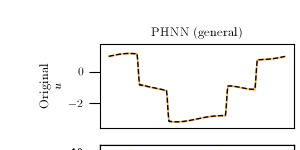

j: 0
j: 1
j: 2
j: 0
j: 1
j: 2


In [20]:
col = 1
lw = 1

fig = plt.figure(figsize=(8, 3.7))

for mp, model_solution in enumerate(all_models):
    if mp > 0:
        m = mp+1
    else:
        m = mp

    u_exact = all_exact[mp]
    model_solutions = all_models[mp]
    u_max, u_min = u_exact.max(), u_exact.min()
    u_max = max(u.max() for (u, _, _) in model_solutions if u is not None)
    u_min = min(u.min() for (u, _, _) in model_solutions if u is not None)
#    u_min = min(max(u_min, -2), -.15)
#     u_max = min(u_max, 6)
#    u_min = -.5
#    u_max = 2.2
        
    for jp, (u, modeltype, _) in enumerate(model_solution):
        j = jp
        print('j:', j)
        #plotdf = df[df['Model type']==modeltype].copy()
        grp = df[df['Model type']==modeltype]
        u_phnn = np.zeros((grp.shape[0], t_sample.shape[0], PDE_system.nstates))
        mse = 0
        for k, modelpath in enumerate(grp.index):
            model, _, metadict = phnn.load_dynamic_system_model(modelfolder+'/'+modelpath)
            if model_solutions[-1][-1]=='No force':
                if modeltype=='Baseline':
                    def basemodel_no_force(u, t, x):
                        return (model.rhs_model(u,t,x) - 
                                model.rhs_model(torch.zeros_like(u),t,x))
                    u_dot = lambda t, u: basemodel_no_force(
                                             torch.tensor(u.reshape(1, u.shape[-1]), dtype=ttype),
                                             torch.tensor(np.array(t).reshape((1, 1)), dtype=ttype),
                                             torch.tensor(x.reshape(1, x.shape[-1]), dtype=ttype)
                                             ).detach().numpy().flatten()
                    out_ivp = solve_ivp(fun=u_dot, t_span=(t_sample[0], t_sample[-1]),
                                        y0=u0.flatten(), t_eval=t_sample, rtol=1e-10)
                    u_phnn[k] = out_ivp['y'].T
                else:
                    phmodel = phnn.ConservativeDissipativeNN(
                                                             PDE_system.nstates,
                                                             kernel_sizes=model.kernel_sizes[:3]+[0],
                                                             structure_matrix=model.S(),
                                                             dissipation_matrix=model.P(),
                                                             symmetric_matrix=model.D_flat(),
                                                             hamiltonian_true=model.hamiltonian,
                                                             grad_hamiltonian_true=model.dH,
                                                             dissintegral_true=model.dissintegral,
                                                             grad_dissintegral_true=model.dV
                                                            )
                    u_phnn[k], _ = phmodel.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
            else:
                u_phnn[k], _ = model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
            #mse += np.mean((u_exact - u_phnn[k])**2)
        meansim = np.mean(u_phnn, axis=0)
        stdsim = np.std(u_phnn, axis=0, ddof=1)
        if u is not None:
            ax1 = fig.add_subplot(3, 3, j+1+3*m)
            if m == 0:
                ax1.set_title(modeltype)
            #ax1.plot(x, u[-1,:], color=custom_colors[j], linewidth=1, label=modeltype)
            l = ax1.plot(x, meansim[-1,:], label=modeltype, color=custom_colors[j], alpha=1., linewidth=lw)
            ax1.fill_between(x, meansim[-1,:]-stdsim[-1,:],
                             meansim[-1,:]+stdsim[-1,:], alpha=0.3, color=l[0].get_color())
            #ax1.plot(x, meansim[int(i*N/4),:], label=integrator, color=custom_colors[0], alpha=1., linewidth=lw)
            ax1.plot(x, u_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
            if m == 2:
                ax1.set_xlabel('$x$')
            else:
                ax1.set_xticks([])
            if j == 0:
                ax1.set_ylabel(model_solution[-1][-1]+'\n$u$')
            else:
                ax1.set_yticks([])
            ax1.set_ylim([1.1*u_min, 1.3*u_max])
    #if m == 0:
    #    ax1.legend(bbox_to_anchor=(-0.6, -2.77), loc='upper center', ncol=3, fancybox=True)

m = 1
F_max, F_min = F_exact.max(), F_exact.min()
F_max = max(F.max() for (F, _, _) in model_forces if F is not None)
F_min = min(F.min() for (F, _, _) in model_forces if F is not None)
#F_min = min(max(F_min, -2), -.15)
#F_max = min(F_max, 6)
#F_min = -.5
#F_max = 2.2
for jp, (F, modeltype, _) in enumerate(model_forces):
    j = jp
    grp = df[df['Model type']==modeltype]
    F_phnn = np.zeros((grp.shape[0], t_sample.shape[0], PDE_system.nstates))
    mse = 0
    if F is not None:
        for k, modelpath in enumerate(grp.index):
            model, _, metadict = phnn.load_dynamic_system_model(modelfolder+'/'+modelpath)
            if modeltype=='Baseline':
                u_model, _ = model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
                F_phnn[k] = model.rhs_model(
                               torch.zeros_like(torch.tensor(u_model.reshape(-1,1,u_model.shape[-1]), dtype=ttype)),
                               torch.tensor(t_sample.reshape(-1,1,1),dtype=ttype),
                               torch.tensor(np.tile(x.reshape(-1, 1, 1), u_model.shape[0]).T, dtype=ttype)
                              ).detach().numpy().reshape(u_model.shape)
            else:
                u_model, _ = model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
                F_model = model.external_forces(torch.tensor(u_model.reshape(-1,1,u_model.shape[-1]), dtype=ttype),
                                                torch.tensor(t_sample.reshape(-1,1,1),dtype=ttype),
                                                torch.tensor(np.tile(x.reshape(-1, 1, 1), u_model.shape[0]).T, dtype=ttype)
                                               ).detach().numpy().reshape(u_model.shape)
                if model.kernel_sizes[0] > 1:
                    d = int((model.kernel_sizes[0]-1)/2)
                    M = x.size
                    D_flat = model.D_flat().detach().numpy()
                    diagonals = np.concatenate([D_flat[0,:,(d+1):], D_flat[0], D_flat[0,:,:-(d+1)]], axis=1).T.repeat(M, axis=1)
                    offsets = np.concatenate([np.arange(-M+1,-M+1+d),np.arange(-d,d+1),np.arange(M-d,M)])
                    D = diags(diagonals, offsets, (M,M)).toarray()
                    F_phnn[k] = np.matmul(PDE_system.lhs_matrix, np.linalg.solve(D, F_model.T)).T
                else:
                    F_phnn[k] = F_model
            meansim = np.mean(F_phnn, axis=0)
            stdsim = np.std(F_phnn, axis=0, ddof=1)
            ax1 = fig.add_subplot(3, 3, j+1+3*m)
            if m == 0:
                ax1.set_title(modeltype)
            #ax1.plot(x, F_model[-1,:], color=custom_colors[j], linewidth=1, label=modeltype) 
            l = ax1.plot(x, meansim[-1,:], label=modeltype, color=custom_colors[j], alpha=1., linewidth=lw)
            ax1.fill_between(x, meansim[-1,:]-stdsim[-1,:],
                             meansim[-1,:]+stdsim[-1,:], alpha=0.2, color=l[0].get_color())
            ax1.plot(x, F_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
            ax1.set_xticks([])
            if j == 0:
                ax1.set_ylabel('$f$')
            else:
                ax1.set_yticks([])
            ax1.set_ylim([1.2*F_min, 1.2*F_max])


#ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
fig.subplots_adjust(wspace=0.1)
fig.savefig('figs/paper/pm_spread_std.pdf', bbox_inches='tight')